r_number (should be less than 0.5): 0.4882335709403379
a_number: 1.9529342837613516e-07
h_number: 360
x (11,)
y (8641,)
snowpack grid shape (11, 8641)


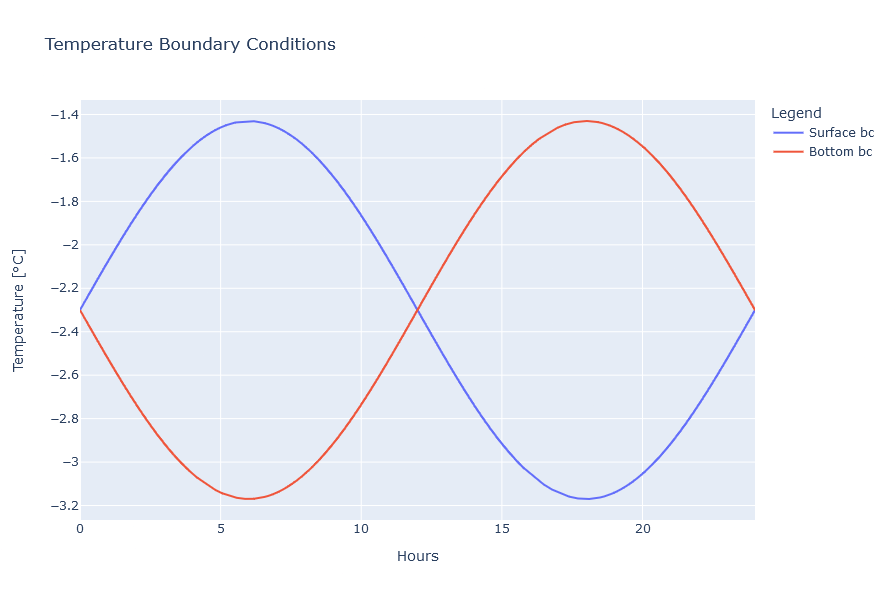

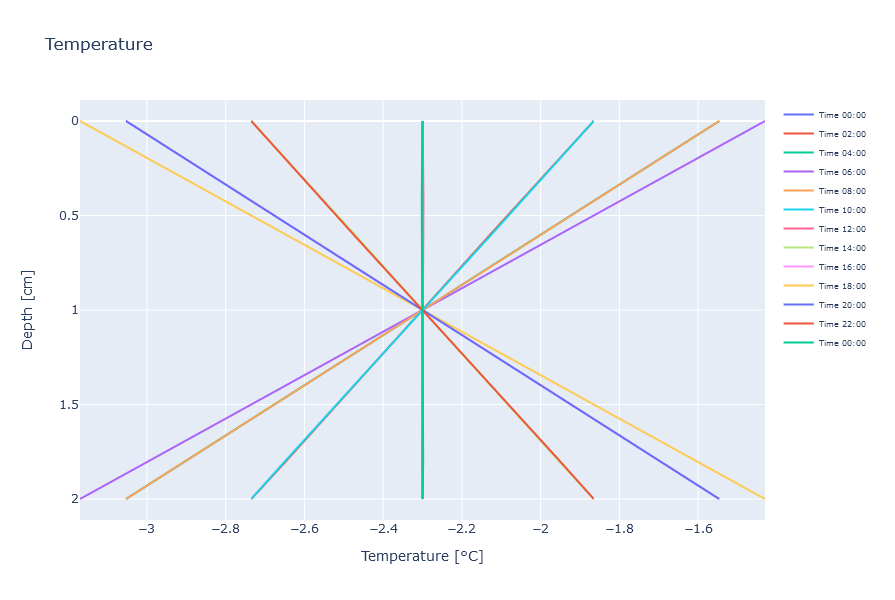

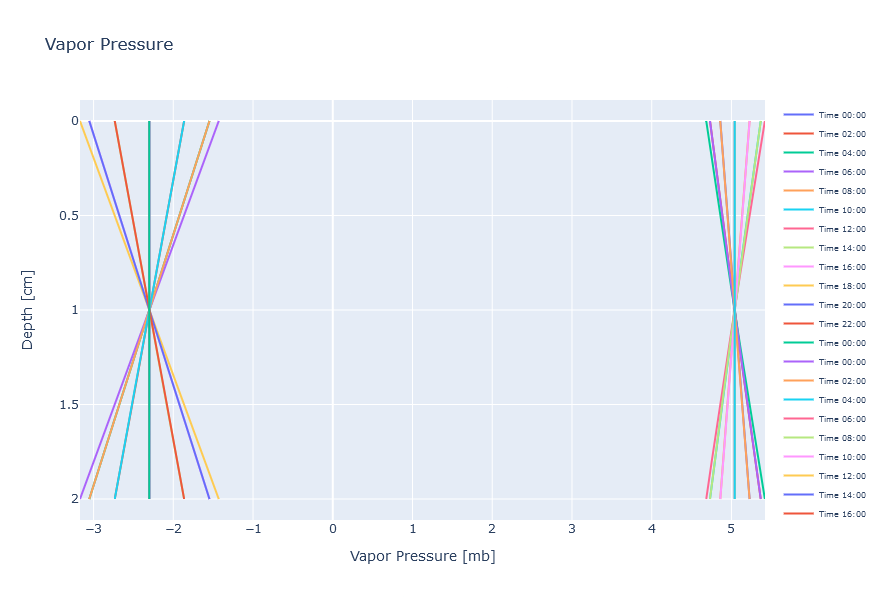

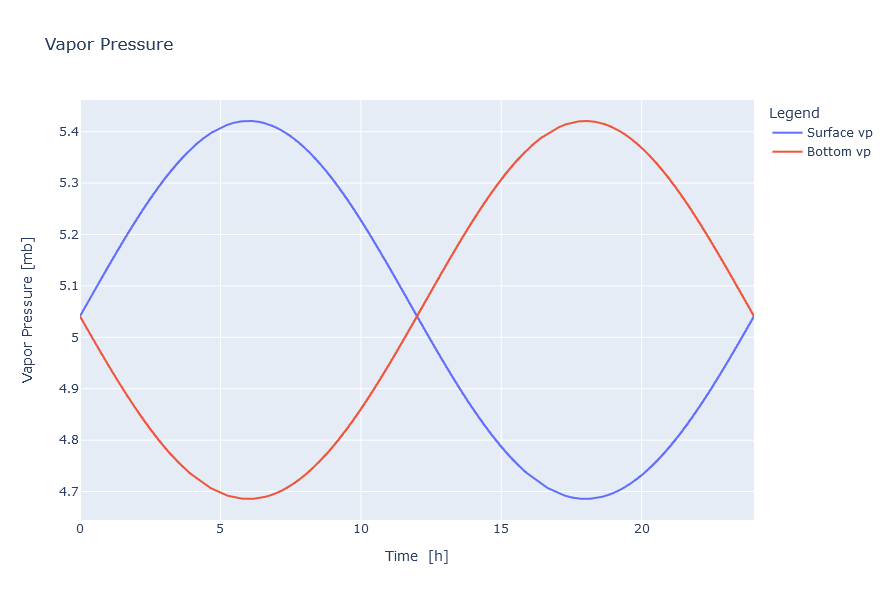

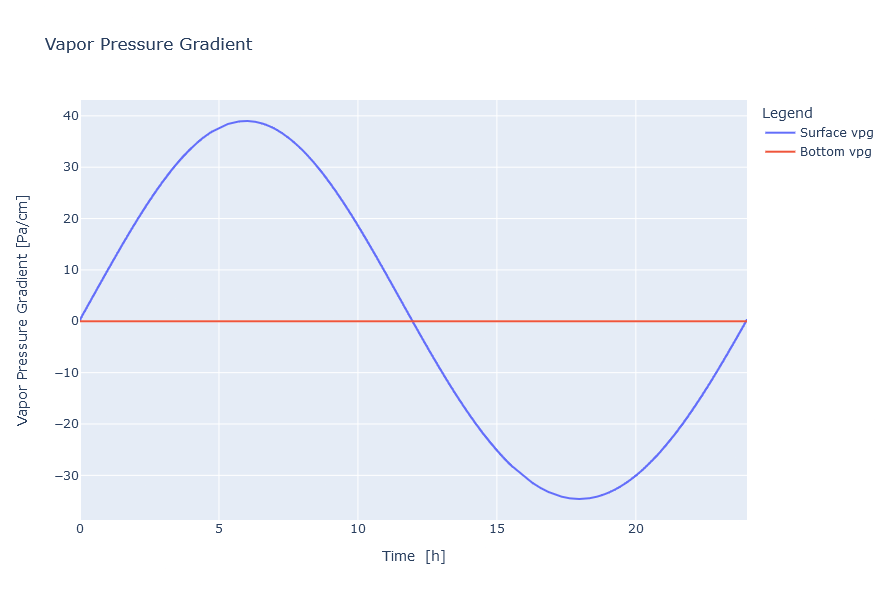

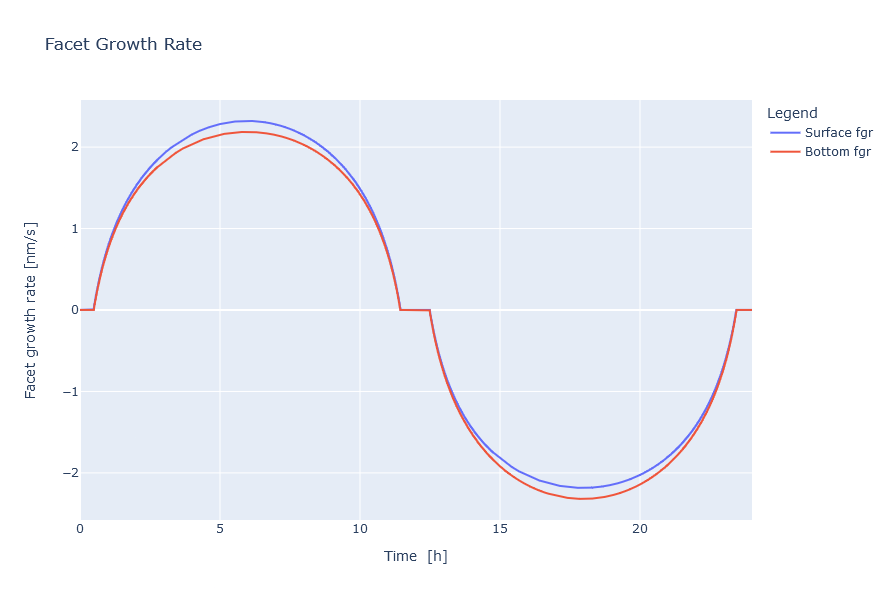

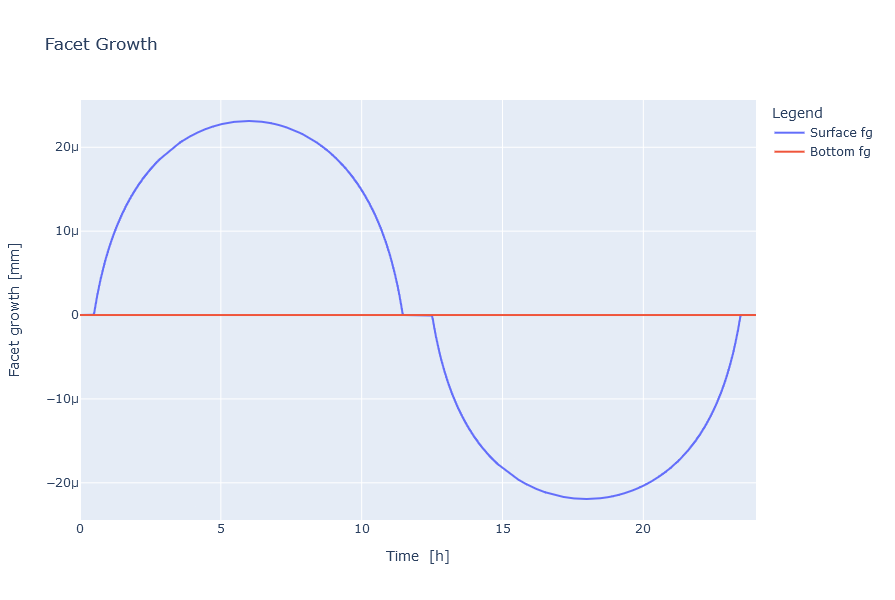

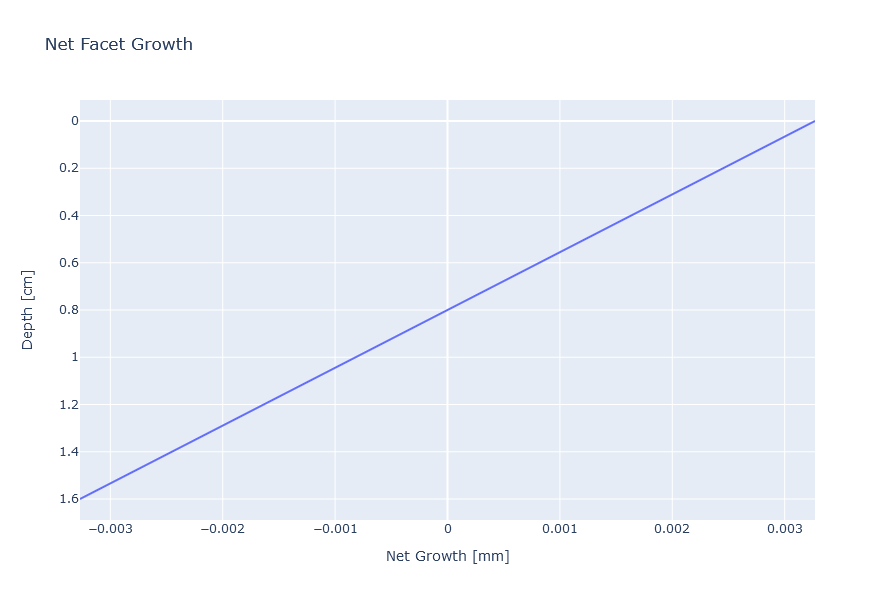

In [52]:
### 1D snowpack temperature simulator ###
# v1.0 
#@author: Ola Thorstensen and Thor Parmentier
# Version update:
# - Pinzer and Schneebeli experiment


import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.graph_objects as go

############################    Parameters   ############################ 
runtime = 24             # Hours
dt = 10                 # Time step [seconds] (Must be a divisor of 3600)
depth = 0.02                # Snow depth from surface [m]
dx = 0.002                # Dist. interval [m]
pm = 2                   # USE INTEGERS. Give hourly plot rate


spin_up = 0            # [0] No spin-up, [1] Run spin-up
sp_runtime = 24*7        # Spin-up run time [Hours]
plot_depth = 0.35           # Depth shown in plots [m]


############################    Constants   ############################   
k = 0.1                  # Thermal conductivity snow [W/m K]
rho = 245                # density [kg/m3]
cp = 2090                # Specific heat capacity of ice [J/kg C]
T0 = 273.16              # Ice-point temperature [K]
a = k/(rho*cp)           # Thermal diffusivity [m2/s]
r = a*(dt/(dx*dx))       # Must be < 0.5 for model stability [1]
h = int((3600/dt))       # Number of dt increments between each whole hour [1]


###########################    Functions    ###########################
def Heat_flow(ix, iy, grid):
    iy = iy-1                                        
    t1 = grid[ix-1, iy]
    t2 = grid[ix, iy] 
    t3 = grid[ix+1, iy]
    T = t2 + r*((-2 * t2) + t1 + t3)     
      
    return T

def Vapor_pressure(ix, iy, T):
    T = T + 273.15
    vp = -9.09718 * ((T0 / T) - 1) -3.56654 * np.log10(T0 / T) 
    vp = vp +0.876793 * (1-(T/T0)) + np.log10(6.1071)
    vp = 10**vp
    
    return vp

def Vapor_pressure_gradient(ix, iy):
    vpg = (vp[ix, iy] - vp[ix + 1, iy]) / dx 
    
    return vpg

def Facet_growth_rate(ix, iy):
    v = vpg[ix, iy]
    if v > 5:
        fgr = 1.1297 * (np.log(v) - np.log(5))
    elif v < -5:
        fgr = -1 * (1.1297 * (np.log(np.abs(v)) - np.log(5)))
    else:
        fgr = 0 
        
    return fgr


def Facet_growth(ix, iy):
    fg = (fgr[ix, iy] + fgr[ix + 1, iy]) / 2 * dt / 10**6
    
    return fg
    
    
#########################    Model domain    #########################

    # Model grid  
nx = int(depth/dx)
ny = int((runtime * 60 * 60) / dt)

temp = np.zeros([nx+1, ny+1])  # Main snowpack grid
vp = np.zeros([nx+1, ny+1])    # Vapor pressure grid
vpg = np.zeros([nx+1, ny+1])    # Vapor pressure gradient grid
fgr = np.zeros([nx+1, ny+1])    # Facet growth rate grid
fg =  np.zeros([nx+1, ny+1])    # Facet growth grid

    # Axis and time
x = np.linspace(0, depth*100, nx+1) # Depth axis
y = np.round( np.arange(0, ny+1, 1) * dt/3600 , 2) # Time axis
base_time = datetime.strptime("00:00", "%H:%M")
y_t = [(base_time + timedelta(hours=hour)).strftime("%H:%M") for hour in y]


    ## Initial condition
# Linear ic
ic = np.linspace(-2.3, -2.3, nx+1)
temp[:, 0] = np.round(ic, 4)

# Fixed bc, diurnal oscillation:
xx = np.linspace(0, 360, int(h * 24) + 1)
bc = 0.87*np.sin(np.deg2rad(xx))-2.3      # Sinusoidal surface bc
b_bc = -0.87*np.sin(np.deg2rad(xx))-2.3   # Opposite sinusoidal bottom bc

bc_dummy = np.delete(bc, 0)
b_bc_dummy = np.delete(b_bc, 0)
sp_bc = bc

# Extends or crops 24h temperature swings to runtime length
if runtime > 24:
    for i in np.arange(1, int(runtime/24)):
        bc = np.concatenate((bc, bc_dummy,), axis=0)
        b_bc = np.concatenate((b_bc, b_bc_dummy,), axis=0)
    # add remainder
    if runtime%24 != 0:
        bc_ext = bc_dummy[0:(int(runtime%24*h))]
        b_bc_ext = b_bc_dummy[0:(int(runtime%24*h))]
        bc = np.concatenate((bc, bc_ext))
        b_bc = np.concatenate((b_bc, b_bc_ext))

if runtime < 24:
    bc = bc[0:int(runtime*h)+1]  # Crops temp forcing
    b_bc = b_bc[0:int(runtime*h)+1]

temp[0,:] = bc
temp[-1,:] = b_bc

# Could move forcing param to "Parameter section" 
    
        
# Prints of shapes and numbers (all are numbers and none are shapes)
print('r_number (should be less than 0.5):', r)
print('a_number:', a)
print('h_number:', h)
print('x', x.shape)
print('y', y.shape)
print('snowpack grid shape', temp.shape)



#####################     Spin up    ##################### 

if spin_up == 1:
    print('Spin-up initiated. Runtime', sp_runtime, 'hours')
    
    if sp_runtime > 24:
        for i in np.arange(1, int(sp_runtime/24)):
            sp_bc = np.concatenate((sp_bc, bc_dummy,), axis=0)
        # add remainder
        if sp_runtime%24 != 0:
            sp_bc_ext = bc_dummy[0:(int(sp_runtime%24*h))]
            sp_bc = np.concatenate((sp_bc, sp_bc_ext))

    if sp_runtime < 24:
        sp_bc = bc[0:int(sp_runtime*h)+1]  # Crops temp forcing


    sp_ny = int((sp_runtime * 60 * 60) / dt) #Spin-up time steps
    sp_y = np.round( np.arange(0, sp_ny+1, 1) * dt/3600 , 2) #Spin-up y-axis
    sp_temp = np.zeros([nx+1, sp_ny+1], dtype=float) # Spin-up temp grid
    sp_temp[:,0] = ic
    sp_temp[0,:] = sp_bc
    sp_temp[-1,:] = b_bc * np.ones(sp_ny+1, dtype=float)  #Fixed bottom bc
    print('dim spin', sp_bc.shape, sp_temp.shape)

    for iy in np.arange(1, sp_ny+1, dtype=int):
        for ix in np.arange(1, nx, dtype=int):
            sp_temp[ix, iy] = Heat_flow(ix, iy, sp_temp)

          
    ic = sp_temp[:, -1]
    temp[:,0] = ic

    plt.plot(sp_temp[:,-1], x, label= f"Time {sp_y[-1]} h") # Plot every whole hour    
    plt.gca().invert_yaxis()
    plt.title('Spin-up end state used for IC')
    plt.xlabel('Temperature [C] ')
    plt.ylabel('Depth [cm]')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()      



#####################     Main Model Loop    ##################### 

for iy in np.arange(1, ny+1, dtype=int):
    for ix in np.arange(1, nx, dtype=int):
        temp[ix, iy] = Heat_flow(ix, iy, temp)
        
for iy in np.arange(0, ny+1, dtype=int):
    for ix in np.arange(0, nx+1, dtype=int):
        vp[ix, iy] = Vapor_pressure(ix, iy, temp[ix, iy])
        
for iy in np.arange(0, ny+1, dtype=int):
    for ix in np.arange(0, nx, dtype=int):
        vpg[ix, iy] = Vapor_pressure_gradient(ix, iy)
        
for iy in np.arange(0, ny+1, dtype=int):
    for ix in np.arange(0, nx, dtype=int):
        fgr[ix, iy] = Facet_growth_rate(ix, iy)
        
for iy in np.arange(0, ny+1, dtype=int):
    for ix in np.arange(0, nx, dtype=int):
        fg[ix, iy] = Facet_growth(ix, iy)

net_growth = np.sum(fg, axis = 1)

###################################################################



# PLot of results:
# BC
fig = go.Figure()
fig.add_trace(go.Scatter(x = y, y = bc, mode='lines', name='Surface bc'))
fig.add_trace(go.Scatter(x = y, y = b_bc, mode='lines', name='Bottom bc'))

fig.update_layout(
    width = 900, height = 600, 
    title='Temperature Boundary Conditions', xaxis_title='Hours', 
    yaxis_title='Temperature [°C]', legend=dict(title='Legend'))
fig.show()

# Temp
fig = go.Figure()
for p in np.arange(0, ny+1, h*pm):
    fig.add_trace(go.Scatter(x=temp[:, p], y=x, mode='lines', name=f'Time {y_t[p]}'))

fig.update_layout(
    width = 900, height = 600,
    title='Temperature', xaxis_title='Temperature [°C]', yaxis_title='Depth [cm]', 
                  yaxis=dict(autorange='reversed'), legend=dict(font=dict(size=8)))
fig.show()

# Vapor pressure
for p in np.arange(0, ny+1, h*pm):
    fig.add_trace(go.Scatter(x=vp[:, p], y=x, mode='lines', name=f'Time {y_t[p]}'
    ))

fig.update_layout(
    width = 900, height = 600, 
    title='Vapor Pressure', xaxis_title='Vapor Pressure [mb]', yaxis_title='Depth [cm]',
                  yaxis=dict(autorange='reversed'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x = y, y = vp[0, :], mode='lines', name='Surface vp'))
fig.add_trace(go.Scatter(x = y, y = vp[10, :], mode='lines', name='Bottom vp'))

fig.update_layout(
    width = 900, height = 600,
    title='Vapor Pressure', xaxis_title='Time  [h]', 
    yaxis_title='Vapor Pressure [mb]', legend=dict(title='Legend'))
fig.show()

# VPG
fig = go.Figure()
fig.add_trace(go.Scatter(x = y, y = vpg[0, :], mode='lines', name='Surface vpg'))
fig.add_trace(go.Scatter(x = y, y = vpg[10, :], mode='lines', name='Bottom vpg'))

fig.update_layout(
    width = 900, height = 600,
    title='Vapor Pressure Gradient', xaxis_title='Time  [h]', 
    yaxis_title='Vapor Pressure Gradient [Pa/cm]', legend=dict(title='Legend'))
fig.show()

# Growth rate
fig = go.Figure()
fig.add_trace(go.Scatter(x = y, y = fgr[0, :], mode='lines', name='Surface fgr'))
fig.add_trace(go.Scatter(x = y, y = fgr[9, :], mode='lines', name='Bottom fgr'))

fig.update_layout(
    width = 900, height = 600,
    title='Facet Growth Rate', xaxis_title='Time  [h]', 
    yaxis_title='Facet growth rate [nm/s]', legend=dict(title='Legend'))
fig.show()

# Growth
fig = go.Figure()
fig.add_trace(go.Scatter(x = y, y = fg[0, :], mode='lines', name='Surface fg'))
fig.add_trace(go.Scatter(x = y, y = fg[10, :], mode='lines', name='Bottom fg'))

fig.update_layout(
    width = 900, height = 600,
    title='Facet Growth', xaxis_title='Time  [h]', 
    yaxis_title='Facet growth [mm]', legend=dict(title='Legend'))
fig.show()

# Net facet growth
fig = go.Figure()
fig.add_trace(go.Scatter(x = net_growth[0:9], y = x, mode='lines', name='Net Growth'))

fig.update_layout(
    width = 900,
    height = 600,
    title='Net Facet Growth',
    xaxis_title='Net Growth [mm]',
    yaxis_title='Depth [cm]',
    yaxis=dict(autorange='reversed'))
fig.show()